In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import sympy as sp
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from IPython.display import display, Markdown
from scipy.optimize import minimize, root_scalar
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import norm
import BondPricing as bp
import AdvancedAnalytics as aa
import yfinance as yf
from datetime import datetime, timedelta

# Customize Seaborn style
sns.set_style("darkgrid", {
    "axes.facecolor": "#2c2c2c",
    "grid.color": "#4d4d4d",
    "grid.linestyle": "--",
    "axes.labelcolor": "#fc8d62",
    "axes.edgecolor": "#66c2a5",
    "xtick.color": "#66c2a5",
    "ytick.color": "#66c2a5",
    "axes.titlecolor": "#f4c542",
    "text.color": "#66c2a5"
})
sns.set_palette("deep")

# Section 1: Bond Analysis

##### Simple Example of a Bond with descriptive statistics and parameters.

In [2]:
Intel_Bond = bp.Bond(maturity="2060-03-25", cr=0.0495, ytm=0.059623, name="Intel Bond 1", freq=2, current_date="2023-10-12", face_value=100)
Intel_Bond.display_parameters()

print(f'As we can see, \ndirty price = ${Intel_Bond.dirty_price():,.2f} and \nclean price = ${Intel_Bond.clean_price():,.2f} \n\nThis makes sense, and helps illustrate the mechanical aspect \nthat accrued interest is playing in the price of a bond. \n\nAccrued interest is ${Intel_Bond.accrued_interest():,.2f}, so \n${Intel_Bond.dirty_price():,.2f} - ${Intel_Bond.accrued_interest():,.2f} = ${Intel_Bond.clean_price():,.2f}')

                                Bond Details
--------------------------------------------------------------------------------------------

Name: Intel Bond 1              Coupon Rate: 4.950%             Period: 180 days                
Face Value: $100.00             Yield Rate: 5.962300%           Days since coupon: 21           
Maturity: 2060-03-25            Current Yield: 5.8032%          N: 73                           
Settled : 2023-10-16            Coupon Frequency: 2             PMT: $2.4750                    
Prev Pmt: 2023-09-25            Mac Duration: 15.688811         Convexity: 399.9654             
Next Pmt: 2024-03-25            Mod Duration: 15.234644         DV01 Per MM: $1299.477368       

                                DirtyPrice: $85.2975237
                                AccruedInt: $0.2887500
                                CleanPrice: $85.0087737
--------------------------------------------------------------------------------------------
As we can see, 
di

##### Example of a Bond Portfolio, can be extended to include more bonds.

In [3]:
bond_A = bp.Bond(maturity="2025-07-15", cr=0.023, ytm=0.0215, name="Bond A", settle="2023-09-21", face_value=100)
bond_B = bp.Bond(maturity="2038-10-01", cr=0.0315, ytm=0.0485, name="Bond B", settle="2023-09-21", face_value=100)
bond_C = bp.Bond(maturity="2041-01-10", cr=0.0405, ytm=0.0550, name="Bond C", settle="2023-09-21", face_value=100)

portfolio_new = bp.BondPortfolio()
portfolio_new.add_bond(bond_A, 10e6)  # $10 MM par value of Bond A
portfolio_new.add_bond(bond_B, 5e6)   # $5 MM par value of Bond B
portfolio_new.add_bond(bond_C, 15e6)  # $15 MM par value of Bond C

portfolio_new.display_parameters()

                                Bond Portfolio Details                               
-------------------------------------------------------------------------------------
  Name   | Coupon Rate  |   Yield    |     D*     |    DV01    |   Weight   | 
-------------------------------------------------------------------------------------
Bond A   | 2.30%        | 2.1500%    | 1.7639     | 177.6045   | 33.33%     | 
Bond B   | 3.15%        | 4.8500%    | 11.2315    | 937.7400   | 16.67%     | 
Bond C   | 4.05%        | 5.5000%    | 11.6716    | 989.0051   | 50.00%     | 
                                  Portfolio Metrics                                  
                           	Market Value: 	$26.9536 Million                          
                                Portfolio D*: 	8.2957                                
                              Portfolio DV01: 	$709.9940                             


## Section 2: Interest Rate Analysis

##### Nelson Siegel Svensson Model for the Zero Rate Curve


(a) Nelson-Siegel Calibration
--------------------------------------------------------------------------------


,DATE,Bond,Yield,Maturity
0,2024-01-10,DGS3MO,5.46,0.25
1,2024-01-10,DGS6MO,5.23,0.50
2,2024-01-10,DGS1,4.82,1.00
3,2024-01-10,DGS2,4.37,2.00
4,2024-01-10,DGS3,4.10,3.00
5,2024-01-10,DGS5,3.99,5.00
6,2024-01-10,DGS7,4.01,7.00
7,2024-01-10,DGS10,4.04,10.00
8,2024-01-10,DGS20,4.35,20.00
9,2024-01-10,DGS30,4.20,30.00



Nelson-Siegel Curve Parameters:
------------------------------
β₀ (Long-term rate): 4.40%
β₁ (Yield curve slope): 1.36%
β₂ (Yield curve curvature): -3.16%
λ: 0.55
------------------------------

(b) Interpretation of β₀
--------------------------------------------------------------------------------

Parameter Interpretations:
β₀: Expected long-term interest rate
β₁: Slope indicates curve's steepness. Positive value: upward-sloping. Negative value: downward-sloping.
β₂: Curvature indicates the hump's position. Positive: hump at short-medium maturities. Negative: hump at longer maturities.
λ: Decay factor
------------------------------

(c) Zero Rates
--------------------------------------------------------------------------------


Maturity,Zero Rate (%)
0.25,5.47
1.00,4.83
2.00,4.35
3.00,4.12
4.00,4.02
5.00,3.98
10.00,4.08
15.00,4.18
20.00,4.23
25.00,4.26


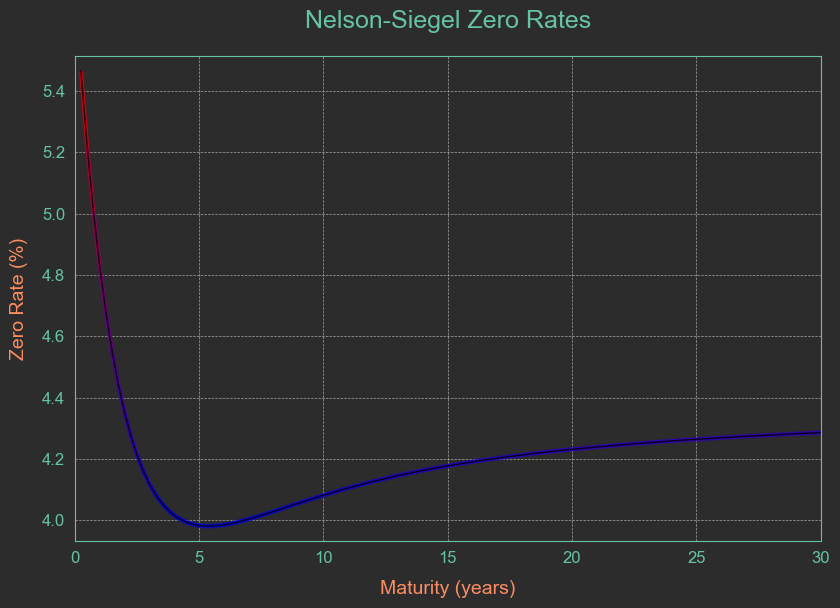


(d) Curve Slope Check
--------------------------------------------------------------------------------

The zero curve slopes upward at some points.
It is inverted around 5.25 and starts increasing at maturity 5.5


In [10]:
# ----------------------------- (a) Nelson-Siegel Calibration -----------------------------
print("\n(a) Nelson-Siegel Calibration")
print("-" * 80)

maturity_dict = {'DGS3MO': 0.25, 'DGS6MO': 0.50, 'DGS1': 1, 'DGS2': 2, 'DGS3': 3, 'DGS5': 5, 'DGS7': 7, 'DGS10': 10, 'DGS20': 20, 'DGS30': 30}
# Original Model: model = aa.NelsonSiegelModel(maturity_dict, '2023-10-26', type='q')
model = aa.NelsonSiegelModel(maturity_dict, '2024-1-10', type='q')
original_rates = model.fetch_bond_data()
original_rates = model.fetch_bond_data()
display(original_rates)
params = model.NS_df.iloc[0]
zero_rates = model.Z['Rate'] / 100 
extended_maturities = model.Z['Maturity']

# Custom curve printout
print("\nNelson-Siegel Curve Parameters:")
print("-" * 30)
print(f"β₀ (Long-term rate): {params.beta0:.2f}%")
print(f"β₁ (Yield curve slope): {params.beta1:.2f}%")
print(f"β₂ (Yield curve curvature): {params.beta2:.2f}%")
print(f"λ: {params['lambda']:.2f}")
print("-" * 30)


# ----------------------------- (b) Interpretation of β₀ -----------------------------
print("\n(b) Interpretation of β₀")
print("-" * 80)
# Parameter Interpretations
interpretations = {
    "β₀": "Expected long-term interest rate",
    "β₁": "Slope indicates curve's steepness. Positive value: upward-sloping. Negative value: downward-sloping.",
    "β₂": "Curvature indicates the hump's position. Positive: hump at short-medium maturities. Negative: hump at longer maturities.",
    "λ": "Decay factor"
}

# Display Interpretations
print("\nParameter Interpretations:")
for param, interp in interpretations.items():
    print(f"{param}: {interp}")
print("-" * 30)  # End separator

# ----------------------------- (c) Zero Rates -----------------------------
print("\n(c) Zero Rates")
print("-" * 80)

desired_maturities = {0.25, 1, 2, 3, 4}.union({x for x in range(5, 31, 5)})
filtered_data = [[maturity, rate*100] for maturity, rate in zip(extended_maturities, zero_rates) if maturity in desired_maturities]
df_zero_rates = pd.DataFrame(filtered_data, columns=["Maturity", "Zero Rate (%)"])
display(df_zero_rates.style.format("{:.2f}").hide().set_caption("Nelson Curve Zero Rates \n(displaying specific mats)"))

def gradient_line(ax, x, y, cmap="RdYlBu_r", norm=None, linewidth=3, alpha=1.0):
    if norm is None:
        norm = plt.Normalize(y.min(), y.max())
    z = np.array([y[:-1], y[1:]]).mean(axis=0)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    lc.set_array(z)
    ax.add_collection(lc)
    return lc

fig, ax = plt.subplots(figsize=(8.5, 10*0.618), facecolor='#2c2c2c')

# Background and cartoonish feel
for spine in ax.spines.values():
    spine.set_color("#66c2a5")
ax.set_facecolor("#2c2c2c")

# Glow effect
alphas = np.linspace(0.05, .5, 10)
sizes = np.linspace(4, 1, 10)
for alpha, size in zip(alphas, sizes):
    gradient_line(ax, extended_maturities, zero_rates*100, cmap=LinearSegmentedColormap.from_list('custom', ['blue', 'purple', 'red']), linewidth=size, alpha=alpha)
ax = sns.lineplot(x=extended_maturities, y=zero_rates*100, color='black', linewidth=1.3, alpha=.5)
ax = sns.lineplot(x=extended_maturities, y=zero_rates*100, color='black', linewidth=.7, alpha=.8)

# Titles, labels and grid
ax.set_title('Nelson-Siegel Zero Rates', fontsize=18, pad=20)
ax.set_xlabel('Maturity (years)', fontsize=14, labelpad=10)
ax.set_ylabel('Zero Rate (%)', fontsize=14, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='#a7a59b')
ax.set_xlim(0, 30)
ax.set_ylim(min(zero_rates*100) - 0.05, max(zero_rates*100) + 0.05)

# Display
plt.tight_layout()
plt.show()

# ----------------------------- (d) Curve Slope Check -----------------------------
print("\n(d) Curve Slope Check")
print("-" * 80)
differences = np.diff(zero_rates)
if all(diff <= 0 for diff in differences):
    print("\nThe zero curve is inverted everywhere.")
elif any(diff > 0 for diff in differences):
    print("\nThe zero curve slopes upward at some points.")

print(f'It is inverted around {len([diff for diff in differences if diff <= 0])/4} and starts increasing at maturity {(np.where(differences > 0)[0][0] + 1)/4}')


##### Accurate NPV Calculations for a Project using the Zero Rate Curve

In [11]:

# ----------------------------- (e) AMC Bond Pricing -----------------------------
print("\n(e) AMC Bond Pricing")
print("-" * 80)
risk_premium = 10.4 / 100
coupon_rate = 6.125 / 100
face_value = 100
years = 5

bond_data = []
for t in range(1, years + 1):  # Assuming years is defined from previous sections
    zero_rate = zero_rates[(t*4)-1]
    effective_rate = zero_rate + risk_premium
    cash_flow = coupon_rate * face_value if t != years else coupon_rate * face_value + face_value
    present_value = cash_flow / (1 + effective_rate)**t
    bond_data.append([t, f"{zero_rate * 100:.2f}%", f"{effective_rate * 100:.2f}%", f"${cash_flow:.2f}", f"${present_value:.2f}"])

# Display Bond Data
columns = ['Year', 'Zero Rate (%)', 'Effective Rate (%)', 'Cash Flow ($)', 'Present Value ($)']
bond_df = pd.DataFrame(bond_data, columns=columns)
print(bond_df)

total_price = bond_df['Present Value ($)'].str.replace("$", "").astype(float).sum()
print(f"\nThe bond's price for AMC Entertainment is: ${total_price:.2f}")

# Proof String for bond_df
proof_string = "Proof: "
for i in range(years):
    proof_string += bond_df['Present Value ($)'][i]
    if i != years - 1:
        proof_string += " + "
proof_string += f"= ${total_price:.2f}"
print(proof_string)

# ----------------------------- (f) NPV Calculation -----------------------------
print("\n(f) NPV Calculation")
print("-" * 80)

cash_flows = [-100, 25, 75, 100, 60, -20]
years = [0, 0.75, 2, 3.25, 4.25, 6.5]

# Ensure the 'Maturity' column in model.Z is rounded to 2 decimal places
model.Z['Maturity'] = model.Z['Maturity'].round(2)

# Lookup the rates for the given years
zero_rates_for_given_maturities = []
for year in years:
    # Find the closest maturity in the DataFrame
    closest_maturity = model.Z.iloc[(model.Z['Maturity'] - year).abs().argsort()[:1]]
    rate = closest_maturity['Rate'].values[0] / 100  # Convert rate to decimal
    zero_rates_for_given_maturities.append(rate)

# Convert the list to a numpy array
zero_rates_for_given_maturities = np.array(zero_rates_for_given_maturities)

# Calculate discounted cash flows for each period
discounted_cash_flows = [cf / (1 + rate)**t for cf, rate, t in zip(cash_flows, zero_rates_for_given_maturities, years)]

# Construct DataFrame for the results
data = {
    "Year": years,
    "Zero Rate (%)": [f"{rate*100:.2f}%" for rate in zero_rates_for_given_maturities],
    "Cash Flow ($)": [f"${cf:.2f}" for cf in cash_flows],
    "Present Value ($)": [f"${dcf:.2f}" for dcf in discounted_cash_flows]
}

df_npv = pd.DataFrame(data)

# Display the DataFrame
print(df_npv)

npv = sum(discounted_cash_flows)
print(f"\nNet Present Value (NPV) of the business investment is: ${npv:.2f}")
print("-" * 80)

# Proof String for df_npv
proof_string = "Proof: "
num_years = len(years)
for i in range(num_years):
    proof_string += df_npv['Present Value ($)'][i]
    if i != num_years - 1:
        proof_string += " + "
proof_string += f"= ${npv:.2f}"
print(proof_string)




(e) AMC Bond Pricing
--------------------------------------------------------------------------------
   Year Zero Rate (%) Effective Rate (%) Cash Flow ($) Present Value ($)
0     1         4.83%             15.23%         $6.12             $5.32
1     2         4.35%             14.75%         $6.12             $4.65
2     3         4.12%             14.52%         $6.12             $4.08
3     4         4.02%             14.42%         $6.12             $3.57
4     5         3.98%             14.38%       $106.12            $54.20

The bond's price for AMC Entertainment is: $71.82
Proof: $5.32 + $4.65 + $4.08 + $3.57 + $54.20= $71.82

(f) NPV Calculation
--------------------------------------------------------------------------------
   Year Zero Rate (%) Cash Flow ($) Present Value ($)
0  0.00         5.47%      $-100.00          $-100.00
1  0.75         5.01%        $25.00            $24.10
2  2.00         4.35%        $75.00            $68.87
3  3.25         4.08%       $100.00 

##### Forward Rate, Investment Decisions, and Near-Term Forward Spread Calculations

In [13]:
model = aa.NelsonSiegelModel(maturity_dict, '2024-1-10', type='d')

# Assuming 'model' is an instance of NelsonSiegelModel
yield_analysis = aa.TreasuryYieldAnalysis(model)

# Compute forward rates
f1_2 = yield_analysis.compute_forward_rate(1, 2)
f2_3 = yield_analysis.compute_forward_rate(2, 3)

# Display forward rates in Markdown format
markdown_f1_2 = yield_analysis.display_forward_rates_markdown(1, 2)
markdown_f2_3 = yield_analysis.display_forward_rates_markdown(2, 3)

# Determine market expectation based on forward rates
market_expectation_markdown = yield_analysis.market_expectation(f1_2, f2_3)


display(Markdown("## Forward Rates"))
### Improve the below to be programmatically generated from whatever inputs get used in compute_forward_rate()
display(Markdown("Compute the forward rates $f_{1\\rightarrow2}$ and $f_{2\\rightarrow3}$ (also referred to as $_1f_2$ and $_2f_3$)."))
display(Markdown("### Solution"))
display(Markdown('The Formula Used is: $f_{start_{year}\\rightarrow end_{year}} = \\frac{(1 + z_{end_{year}})^{end_{year}}}{(1 + z_{start_{year}})^{start_{year}}} - 1$'))
display(Markdown(f'- {markdown_f1_2}'))
display(Markdown(f'- {markdown_f2_3}'))

display(Markdown("---"))
display(Markdown("## Market Expectation"))
display(Markdown(market_expectation_markdown))\

# Define the expected rate for the first year
expected_rate_first_year = 0.0413  # 4.13% as a decimal

# Define the investment horizon (e.g., 2 years)
investment_horizon = 2

# Compute and display investment decision in Markdown format
investment_decision_md = yield_analysis.investment_decision_markdown(investment_horizon, expected_rate_first_year)

# Display the investment decision
display(Markdown("---"))
display(Markdown(investment_decision_md))


display(Markdown("Compute the value of the NTFS - To compute $f_{1.50\\rightarrow1.75}$ the no arbitrage condition is based on investing for 7 quarters such that $$(1 + z_{1.75})^{1.75} = (1 + z_{1.50})^{1.50} \\times (1 + f_{1.50\\rightarrow1.75})^{0.25}$$."))
ntfs_markdown = yield_analysis.compute_NTFS_markdown(1.5, 1.75, 0.25)  # Using 1.5 years, 1.75 years, and 3-month T-bill
display(Markdown(ntfs_markdown))
display(Markdown("---"))


## Forward Rates

Compute the forward rates $f_{1\rightarrow2}$ and $f_{2\rightarrow3}$ (also referred to as $_1f_2$ and $_2f_3$).

### Solution

The Formula Used is: $f_{start_{year}\rightarrow end_{year}} = \frac{(1 + z_{end_{year}})^{end_{year}}}{(1 + z_{start_{year}})^{start_{year}}} - 1$

- $f_{1\rightarrow2}$ = 3.88%

- $f_{2\rightarrow3}$ = 3.65%

---

## Market Expectation

(b) Given the forward rates, The market expects the 1-year interest rate to **_decrease_** in the next year and to **_decrease_** in the following year.

---


## Investment Decision for 2-Year Horizon
- Current 1-year spot rate: **4.83%**
- Current 2-year spot rate: **4.35%**
- Expected $f_{1\rightarrow2}$: **4.13%**

- Formula for investing in a 2-year bond:
  - Total Return = (($1 + z_2)^2) - 1$
  - Where $z_2$ is the current 2-year spot rate.
  - Total Return: **8.90%**
  
- Formula for rolling over one-year bonds:
  - Total Return for $\text{First Year} = 1 + z_1$
  - Total Return for Second Year = $(1 + z_1) \times (1 + E[z_1]) - 1$
  - Where $z_1$ is the current 1-year spot rate and $E[z_1]$ is the expected 1-year spot rate for the second year.
  - Total Return: **9.16%**

Based on the total returns, **rolling over bonds** is better.


Compute the value of the NTFS - To compute $f_{1.50\rightarrow1.75}$ the no arbitrage condition is based on investing for 7 quarters such that $$(1 + z_{1.75})^{1.75} = (1 + z_{1.50})^{1.50} \times (1 + f_{1.50\rightarrow1.75})^{0.25}$$.


## Near-Term Forward Spread (NTFS) Calculation

- **Input Rates**:
  - Spot rate for 1.5 years $z_{1.5}$: **4.55%**
  - Spot rate for 1.75 years $z_{1.75}$: **4.44%**
  - 3-month T-bill rate $z_{0.25}$: **5.46%**

- **Forward Rate Calculation**:
  - Formula: $f_{1.5\rightarrow1.75} = \left(\frac{(1 + z_{1.75})^{1.75}}{(1 + z_{1.5})^{1.5}}\right)^{\frac1{end - start}} - 1$
  - Calculated Forward Rate: **3.7976%**

- **NTFS Calculation**:
  - Formula: $NTFS = f_{1.5\rightarrow1.75} - z_{0.25}$
  - NTFS Value: **-1.662368%**



---

##### Section 4: Repo Analysis and Strategies

In [14]:
# Initialize the Bond object
bond = bp.Bond('2039-07-31', 0.035, 0.042, settle='2023-11-13', freq=2)

# Initialize the RepoTransactionAnalysis object for a repo
repo_analysis = aa.RepoTransactionAnalysis(bond, 0.075, 0.03, 'repo')

# Initialize the RepoTransactionAnalysis object for a reverse repo
reverse_repo_analysis = aa.RepoTransactionAnalysis(bond, 0.075, 0.03, 'reverse_repo')

# Display transaction type and profit/loss calculations
repo_analysis.display_transaction_type()
repo_analysis.display_profit_loss(0.0435, pd.Timestamp('2023-11-16'))

reverse_repo_analysis.display_transaction_type()
reverse_repo_analysis.display_profit_loss(0.0435, pd.Timestamp('2023-11-16'))


### (a) Transaction Type
- **Repo**


## Repo Profit/Loss Calculation
- Initial Bond Price (Before YTM Change): **$92.9921**
- Updated YTM for Bond Buyback: **4.3500%**
- Final Bond Price (After YTM Change): **$91.3816**
- Haircut Rate: **3.00%**
- Lent Amount (after haircut): **$90.2023**
- Days Between Transactions: **3 days**
- Repo Rate: **7.50%**
- Interest for Repo Rate: **$-0.05638**
- Total Profit/Loss in Dollars: **$-1.666874**
- Total Profit/Loss as % of Lent Capital: **-184.7928%**

## Break-even Bond Price
- Initial Bond Price: **$92.9921**
- Interest for Repo Rate: **$-0.05638**
- Break-even Price for Repo: **$92.93569**


### (a) Transaction Type
- **Reverse_repo**


## Reverse_repo Profit/Loss Calculation
- Initial Bond Price (Before YTM Change): **$92.9921**
- Updated YTM for Bond Buyback: **4.3500%**
- Final Bond Price (After YTM Change): **$91.3816**
- Haircut Rate: **3.00%**
- Lent Amount (after haircut): **$90.2023**
- Days Between Transactions: **3 days**
- Repo Rate: **7.50%**
- Interest for Reverse Repo Rate: **$0.05638**
- Total Profit/Loss in Dollars: **$1.666874**
- Total Profit/Loss as % of Lent Capital: **184.7928%**

## Break-even Bond Price
- Initial Bond Price: **$92.9921**
- Interest for Reverse Repo Rate: **$0.05638**
- Break-even Price for Reverse_repo: **$93.04845**


##### Section 5: Expected Default Frequency, Z-Spread, and Credit Risk



| Company | Settlement  | Maturity    | Coupon Rate | YTM   | Dirty Price | Z-Spread (bps) |
|---------|-------------|-------------|-------------|-------|-------------|----------------|
| HD | 2023-12-18 | 2036-12-16 | 5.875% | 4.97% | 108.6466 | 0.7057 |


                                Bond Details
--------------------------------------------------------------------------------------------

Name: Bond                      Coupon Rate: 5.875%             Period: 180 days                
Face Value: $100.00             Yield Rate: 4.967000%           Days since coupon: 2            
Maturity: 2036-12-16            Current Yield: 5.4074%          N: 26                           
Settled : 2023-12-18            Coupon Frequency: 2             PMT: $2.9375                    
Prev Pmt: 2023-12-16            Mac Duration: 9.433894          Convexity: 112.8043             
Next Pmt: 2024-06-17            Mod Duration: 9.205280          DV01 Per MM: $1000.122752       

                                DirtyPrice: $108.6466363
                                AccruedInt: $0.0326389
                                CleanPrice: $108.6139974
--------------------------------------------------------------------------------------------


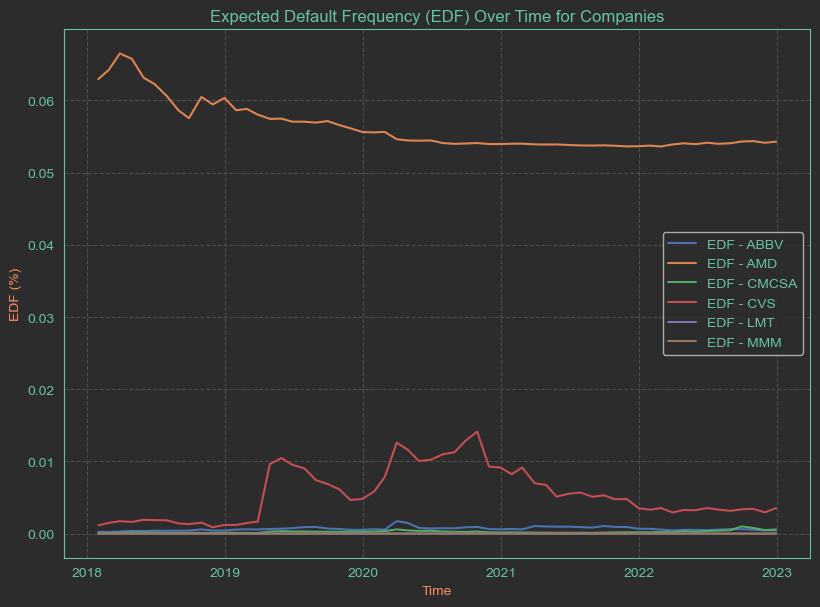

| Company | Settlement  | Maturity    | Coupon Rate | YTM   | Dirty Price | Z-Spread (bps) |
|---------|-------------|-------------|-------------|-------|-------------|----------------|
| 3M | 2023-11-21 | 2046-09-19 | 3.125% | 5.68% | 68.0735 | 1.0143 |
| ABBVIE | 2023-11-21 | 2036-05-14 | 4.300% | 5.35% | 90.6092 | 0.8427 |
| AMD | 2023-11-21 | 2032-06-01 | 3.924% | 5.10% | 93.7987 | 0.3349 |
| CVS | 2023-11-21 | 2039-09-15 | 6.125% | 6.12% | 101.1576 | 1.4761 |
| Comcast | 2023-11-21 | 2040-01-03 | 6.400% | 6.09% | 105.5906 | 1.3273 |
| Lockheed | 2023-11-21 | 2041-09-15 | 4.850% | 5.96% | 88.7879 | 1.3103 |
| NetFlix | 2023-11-21 | 2029-11-15 | 5.375% | 5.51% | 99.3859 | 1.0530 |


In [16]:
# ----------------------------- (a) Z-Spread -----------------------------
analytics = aa.BondAnalytics(maturity_dict, '2023-12-05')

# Define bond instances
bond_instances = {
    "HD": bp.Bond(maturity="2036-12-16", cr=0.05875, ytm=0.04967, settle="2023-12-16", freq=2) 
}

# First, create the header and the rows
markdown_table = "| Company | Settlement  | Maturity    | Coupon Rate | YTM   | Dirty Price | Z-Spread (bps) |\n"
markdown_table += "|---------|-------------|-------------|-------------|-------|-------------|----------------|\n"

# Loop over bond instances to compute dirty price and Z-spread and add to the table
for company, bond in bond_instances.items():
    dirty_price = bond.dirty_price()
    z_spread_bps = analytics.calculate_z_spread(bond)
    markdown_table += f"| {company} | {bond.settle.strftime('%Y-%m-%d')} | {bond.maturity.strftime('%Y-%m-%d')} | {bond.cr:.3%} | {bond.ytm:.2%} | {dirty_price:.4f} | {z_spread_bps:.4f} |\n"

# Finally, display the Markdown table
display(Markdown(markdown_table))
#test HD
bond_instances['HD'].display_parameters()


model = aa.BlackScholesModel('EDF_data.csv')
model.plot_EDF()

maturity_dict = {'DGS3MO': 0.25, 'DGS6MO': 0.50, 'DGS1': 1, 'DGS2': 2, 'DGS3': 3, 'DGS5': 5, 'DGS7': 7, 'DGS10': 10, 'DGS20': 20, 'DGS30': 30}
analytics = aa.BondAnalytics(maturity_dict, '2023-11-21')

# Define bond instances
bond_instances = {
    "3M": bp.Bond(maturity='2046-09-19', cr=3.125/100, ytm=5.68/100, settle='2023-11-21', freq=2),
    "ABBVIE": bp.Bond(maturity='2036-05-14', cr=4.300/100, ytm=5.35/100, settle='2023-11-21', freq=2),
    "AMD": bp.Bond(maturity='2032-06-01', cr=3.924/100, ytm=5.10/100, settle='2023-11-21', freq=2),
    "CVS": bp.Bond(maturity='2039-09-15', cr=6.125/100, ytm=6.12/100, settle='2023-11-21', freq=2),
    "Comcast": bp.Bond(maturity='2040-01-03', cr=6.400/100, ytm=6.09/100, settle='2023-11-21', freq=2),
    "Lockheed": bp.Bond(maturity='2041-09-15', cr=4.850/100, ytm=5.96/100, settle='2023-11-21', freq=2),
    "NetFlix": bp.Bond(maturity='2029-11-15', cr=5.375/100, ytm=5.514092/100, settle='2023-11-21', freq=2),
}

# First, create the header and the rows
markdown_table = "| Company | Settlement  | Maturity    | Coupon Rate | YTM   | Dirty Price | Z-Spread (bps) |\n"
markdown_table += "|---------|-------------|-------------|-------------|-------|-------------|----------------|\n"

# Loop over bond instances to compute dirty price and Z-spread and add to the table
for company, bond in bond_instances.items():
    dirty_price = bond.dirty_price()
    z_spread_bps = analytics.calculate_z_spread(bond)
    markdown_table += f"| {company} | {bond.settle.strftime('%Y-%m-%d')} | {bond.maturity.strftime('%Y-%m-%d')} | {bond.cr:.3%} | {bond.ytm:.2%} | {dirty_price:.4f} | {z_spread_bps:.4f} |\n"

# Finally, display the Markdown table
display(Markdown(markdown_table))


Ford and GM Analysis

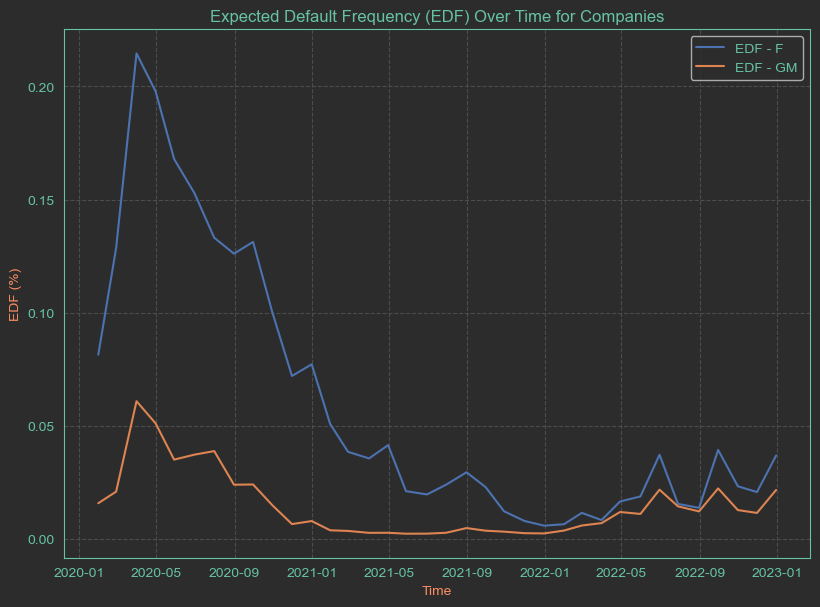

### Results for F

**Highest Distance to Default:** 2.28 on 2021-12-31

**Lowest Distance to Default:** 0.68 on 2020-03-31

### Results for GM

**Highest Distance to Default:** 2.84 on 2021-05-28

**Lowest Distance to Default:** 1.54 on 2020-03-31

In [18]:
model = aa.BlackScholesModel('FinalEx_data.csv')
model.plot_EDF()
EDF_Example = model.iterate_calculations(model.df)

for ticker in EDF_Example['ticker'].unique():
    filtered_df = EDF_Example[EDF_Example['ticker'] == ticker]
    
    max_dd = filtered_df['DtD'].max()
    min_dd = filtered_df['DtD'].min()
    max_dd_date = filtered_df[filtered_df['DtD'] == max_dd]['date'].iloc[0]
    min_dd_date = filtered_df[filtered_df['DtD'] == min_dd]['date'].iloc[0]

    display(Markdown(f"### Results for {ticker}"))
    display(Markdown(f"**Highest Distance to Default:** {max_dd:.2f} on {max_dd_date.strftime('%Y-%m-%d')}"))
    display(Markdown(f"**Lowest Distance to Default:** {min_dd:.2f} on {min_dd_date.strftime('%Y-%m-%d')}"))

##### Bonus Section on comparison between SPY and HYG

In [ ]:
# set to pastelle
sns.set_palette("pastel")

# Download monthly prices of SPY and HYG starting from the financial crisis (January 2008)
spy_data = yf.download('SPY', start='2008-01-01', interval='1mo', progress=False)
hyg_data = yf.download('HYG', start='2008-01-01', interval='1mo', progress=False)

# Calculate the monthly returns
spy_returns = spy_data['Adj Close'].pct_change().dropna()
hyg_returns = hyg_data['Adj Close'].pct_change().dropna()

# Combine the returns into a single DataFrame
combined_returns = pd.DataFrame({
    'SPY': spy_returns,
    'HYG': hyg_returns
}).dropna()

# Function for styling individual plots
def style_plot(ax, title, ylabel='', xlabel='Date'):
    ax.set_title(title, color="#f4c542", fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, color="#fc8d62", fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel, color="#fc8d62", fontsize=10, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=8, colors='#66c2a5')

    for spine in ax.spines.values():
        spine.set_color("#66c2a5")
    ax.set_facecolor("#2c2c2c")
    ax.grid(True, which='both', color="#4d4d4d", linestyle="--", linewidth=0.5)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=8, facecolor="#2c2c2c", edgecolor="#2c2c2c")

# Create and display plots
plot_titles = ['Monthly Returns of SPY vs HYG', 'Cumulative Returns of SPY vs HYG', 'Rolling 12-Month Correlation of SPY vs HYG', 'Correlation Heatmap of SPY vs HYG']

for i, title in enumerate(plot_titles):
    plt.figure(figsize=(9.5, 6), facecolor='#2c2c2c')  # Reduced height
    ax = plt.gca()
    style_plot(ax, title)
    
    if i == 0:
        combined_returns.plot(ax=ax)
        ax.legend(['SPY', 'HYG'])
    elif i == 1:
        cumulative_returns = (1 + combined_returns).cumprod()
        cumulative_returns.plot(ax=ax)
        ax.legend(['SPY', 'HYG'])
    elif i == 2:
        rolling_correlation = combined_returns['SPY'].rolling(12).corr(combined_returns['HYG'])
        rolling_correlation.plot(ax=ax)
    elif i == 3:
        sns.heatmap(combined_returns.corr(), annot=True, cmap='coolwarm', center=0, ax=ax)
    
    plt.tight_layout()  # Adjusts subplot parameters for reduced margins
    plt.show()

##### Section 6, Mortage Backed Securities Pricing

In [22]:
maturity_dict = {'DGS3MO': 0.25, 'DGS6MO': 0.50, 'DGS1': 1, 'DGS2': 2, 'DGS3': 3, 'DGS5': 5, 'DGS7': 7, 'DGS10': 10, 'DGS20': 20, 'DGS30': 30}
model = aa.NelsonSiegelModel(maturity_dict, '2023-12-05', type='m')

zero_rates_df = model.calculate_Z()
monthly_zero_rates = zero_rates_df['Rate'].values / 100  # Convert to decimal

# Given MBS parameters are assumed to be defined
principal_value = 350               # in millions, representing $1 billion
wam = 360                           # Weighted Average Maturity in months
wac = 0.068                         # Weighted Average Coupon
fees = 0.0075                       # Fees as a fraction of the coupon
actual_rate = (wac - fees) / 12     # Actual monthly rate to investors
cpr = 0.045                          # Conditional Prepayment Rate

# ----------------------------- (a) Monthly Prepayment Proportion -----------------------------
# Convert annual CPR to monthly prepayment rate
monthly_prepayment_rate = 1 - (1 - cpr)**(1/12)
print(f'Monthly prepayment proportion: {monthly_prepayment_rate:.4%}')
# Monthly interest rate
monthly_rate = (wac - fees) / 12

# Initial coupon payment
coupon = principal_value * monthly_rate / (1 - (1 / (1 + monthly_rate))**wam)

# Cash flow DataFrame
CF = pd.DataFrame({
    'Month': np.arange(1, wam + 1),
    'p': np.full(wam, monthly_prepayment_rate),
    'L': np.nan,
    'Coupon': np.nan,
    'C.Interest': np.nan,
    'C.Principal': np.nan,
    'Prepay': np.nan,
    'Total.CF': np.nan,
    'PV': np.nan
})

# Calculate cash flows for each month
for i in range(wam):
    if i == 0:
        CF.at[i, 'L'] = principal_value
        CF.at[i, 'Coupon'] = coupon
    else:
        CF.at[i, 'L'] = CF.at[i-1, 'L'] - CF.at[i-1, 'C.Principal'] - CF.at[i-1, 'Prepay']
        CF.at[i, 'Coupon'] = CF.at[i-1, 'Coupon'] * (1 - CF.at[i-1, 'p'])

    CF.at[i, 'C.Interest'] = CF.at[i, 'L'] * monthly_rate
    CF.at[i, 'C.Principal'] = CF.at[i, 'Coupon'] - CF.at[i, 'C.Interest']
    CF.at[i, 'Prepay'] = CF.at[i, 'p'] * CF.at[i, 'L']
    CF.at[i, 'Total.CF'] = CF.at[i, 'Coupon'] + CF.at[i, 'Prepay']

# Discount cash flows to present value using zero rates
CF['PV'] = CF.apply(lambda row: row['Total.CF'] / ((1 + monthly_zero_rates[int(row['Month']) - 1] / 2)**(row['Month'] / 6)), axis=1)

# ----------------------------- (b) MBS Price -----------------------------
# Sum the present values to get the MBS price
MBS_price = CF['PV'].sum()
print('MBS price: ${:,.2f}'.format(MBS_price) + ' million')


# ----------------------------- (c) MBS with PSA -----------------------------
# PSA Model Parameters for Solution #2
PSA_start_CPR = 0.002
PSA_increment = 0.002
PSA_max_CPR = 0.06
PSA_max_month = 30  # Month when CPR reaches 6%

# Given parameters for MBS
principal_value_2 = 500                 # in millions, representing $500 million
wam_2 = 200                             # weighted average maturity in months for the second MBS
wac_2 = 0.06                            # weighted average coupon for the second MBS
fees_2 = 0.005                          # fees of the coupon for the second MBS
actual_rate_2 = (wac_2 - fees_2) / 12   # actual monthly rate to investors for the second MBS

# Initialize cash flow DataFrame for the second MBS
months = np.arange(1, wam_2 + 1)
CF_2 = pd.DataFrame({'Month': months})

# Calculate PSA CPR for each month and convert it to monthly prepayment rate
PSA_CPR = PSA_start_CPR + PSA_increment * np.clip(months - 1, 0, PSA_max_month - 1)
PSA_CPR = np.minimum(PSA_CPR, PSA_max_CPR)  # Cap the CPR at 6%
CF_2['p'] = 1 - (1 - PSA_CPR)**(1/12)

# Calculate the first coupon payment for the second MBS
L_2 = principal_value_2                       # Principal for the second MBS
r_2 = actual_rate_2                           # Monthly interest rate for the second MBS
N_2 = wam_2                                   # Total number of periods (months) for the second MBS
C_2 = L_2 * r_2 / (1 - (1 / (1 + r_2))**N_2)  # Initial coupon payment for the second MBS

# Initial values for the first period
CF_2.loc[0, ['L', 'Coupon', 'C.Interest', 'C.Principal', 'Prepay', 'Total.CF']] = \
    [L_2, C_2, L_2 * r_2, C_2 - L_2 * r_2, CF_2.loc[0, 'p'] * L_2, C_2 + CF_2.loc[0, 'p'] * L_2]

# Calculate cash flows for all future periods for the second MBS
for i in range(1, N_2):
    prev_row = CF_2.loc[i - 1]
    CF_2.loc[i, 'L'] = prev_row['L'] - prev_row['C.Principal'] - prev_row['Prepay']
    CF_2.loc[i, 'Coupon'] = (1 - prev_row['p']) * prev_row['Coupon']
    CF_2.loc[i, 'C.Interest'] = CF_2.loc[i, 'L'] * r_2
    CF_2.loc[i, 'C.Principal'] = CF_2.loc[i, 'Coupon'] - CF_2.loc[i, 'C.Interest']
    CF_2.loc[i, 'Prepay'] = CF_2.loc[i, 'p'] * CF_2.loc[i, 'L']
    CF_2.loc[i, 'Total.CF'] = CF_2.loc[i, 'Coupon'] + CF_2.loc[i, 'Prepay']

# Adjusting the monthly_zero_rates to match the wam_2 period
if len(monthly_zero_rates) > wam_2:
    adjusted_monthly_zero_rates = monthly_zero_rates[:wam_2]
elif len(monthly_zero_rates) < wam_2:
    # Extend the array with the last rate value to match wam_2
    last_rate = monthly_zero_rates[-1]
    rates_to_add = np.full(wam_2 - len(monthly_zero_rates), last_rate)
    adjusted_monthly_zero_rates = np.concatenate((monthly_zero_rates, rates_to_add))
else:
    adjusted_monthly_zero_rates = monthly_zero_rates

# Recompute the discount factors
discount_factors = (1 + adjusted_monthly_zero_rates / 2) ** (CF_2['Month'] / 6)
CF_2['PV'] = CF_2['Total.CF'] / discount_factors

# Sum the present values to get the MBS price for the second MBS
MBS_price_2 = CF_2['PV'].sum().round(2)
print(f'\nThe MBS price using the PSA Model is: ${MBS_price_2:,.2f} million')

Monthly prepayment proportion: 0.3830%
MBS price: $404.09 million

The MBS price using the PSA Model is: $539.06 million
